### LightGBM + ADSTuner
* added feature engineering
* added year, removed temp
* removing day I got the best results. (The range of days in the train set don't match with test set)


In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb

# to use ADSTuner
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *

# to encode categoricals
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import make_scorer

import seaborn as sns
import matplotlib.pyplot as plt

# see utils.py
from utils import add_features, rmsle, train_encoders, apply_encoders
from utils import show_tuner_results, show_categoricals

# set seaborn look&feel
sns.set()

In [2]:
# globals and load train dataset

STUDY_NAME = "Bike sharing11"

# number of folds for K-fold cv in ADSTuner
FOLDS = 7

# in secs
TIME_BUDGET = 3600

FILE_TRAIN = "train.csv"
FILE_TEST = "test.csv"

In [3]:
# load train dataset
data_orig = pd.read_csv(FILE_TRAIN)

#
# add features
#
data_extended = add_features(data_orig)

# have a look
data_extended.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,2012
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,2012
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,2012
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,2012
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23,2012


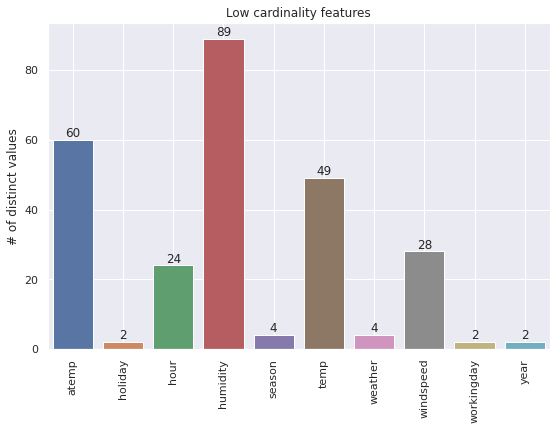

In [4]:
show_categoricals(data_extended, thr=100)

In [5]:
# ok, we will treat as categorical: holiday, hour, season, weather, windspeed, workingday, year

In [6]:
all_columns = data_extended.columns

# cols to be ignored
# atemp and temp are strongly correlated (0.98) we're taking only one
del_columns = ["datetime", "casual", "registered", "temp"]

TARGET = "count"
cat_cols = ["season", "holiday", "workingday", "weather", "windspeed", "hour", "year"]
num_cols = list(set(all_columns) - set([TARGET]) - set(del_columns) - set(cat_cols))
features = sorted(cat_cols + num_cols)

print("All columns:", len(all_columns))
print("Ignored columns:", len(del_columns))
print("Target:", len([TARGET]))
print("Categorical columns:", len(cat_cols))
print("Numerical columns:", len(num_cols))
print("All the features", len(features))

All columns: 14
Ignored columns: 4
Target: 1
Categorical columns: 7
Numerical columns: 2
All the features 9


In [7]:
# drop ignored columns
data_used = data_extended.drop(del_columns, axis=1)

In [8]:
# let's code categorical
# windspeed need a special treatment
le_list = train_encoders(data_extended)

# coding
data_used = apply_encoders(data_used, le_list)

# define indexes for cat_cols
# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(features) if col in cat_cols]

train for coding: season 
train for coding: weather 
train for coding: year 

Coding: season 
Coding: weather 
Coding: year 


### ADSTuner session

In [9]:
#
# Here we define the strategy, the space for hyper-parameters we want to explore
#
params = {
    "n_estimators": CategoricalDistribution([1000, 2000, 3000, 4000, 5000]),
    "learning_rate": LogUniformDistribution(low=1e-4, high=1e-2),
    "max_depth": IntUniformDistribution(5, 10),
    "use_best_model": True,
    "categorical_feature": cat_columns_idxs,
}

alg_reg = lgb.LGBMRegressor()

# define the scorer function for ADSTuner, see def for rmsle before
scorer = make_scorer(rmsle, greater_is_better=False)

# per lista scorer sorted(sklearn.metrics.SCORERS.keys())
tuner = ADSTuner(
    alg_reg, cv=FOLDS, strategy=params, scoring=scorer, study_name=STUDY_NAME
)

x_train = data_used[features]
y_train = data_used[TARGET]

tuner.tune(x_train, y_train, exit_criterion=[TimeBudget(TIME_BUDGET)])

[I 2022-03-03 12:11:29,083] A new study created in RDB with name: Bike sharing11


### Analyze trials

In [70]:
# get the status to see if completed
print(f"The tuner status is: {tuner.get_status()}")

print(f"Remaining time is: {round(tuner.time_remaining, 1)} sec.")

The tuner status is: State.COMPLETED
Remaining time is: 0 sec.


In [71]:
# look only at completed trials, sorted with best on top. Metric chosen is in the value col.
result_df = tuner.trials[tuner.trials["state"] == "COMPLETE"].sort_values(
    by=["value"], ascending=False
)

result_df.head(10)

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,user_attrs_mean_fit_time,user_attrs_mean_score_time,...,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_split5_test_score,user_attrs_split6_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
208,208,-0.487802,2022-03-03 13:06:32.544312,2022-03-03 13:06:45.054086,0 days 00:00:12.509774,0.007325,9,2000,1.628633,0.129110,...,-0.396377,-0.393707,-0.486238,-0.430315,-0.430602,-0.469065,0.020149,0.004897,0.134625,COMPLETE
219,219,-0.488438,2022-03-03 13:09:00.737161,2022-03-03 13:09:13.132700,0 days 00:00:12.395539,0.007239,9,2000,1.612526,0.127718,...,-0.413931,-0.392609,-0.489340,-0.436934,-0.420732,-0.459768,0.027787,0.004751,0.132816,COMPLETE
150,150,-0.489033,2022-03-03 12:52:54.969254,2022-03-03 12:53:07.552422,0 days 00:00:12.583168,0.005227,8,2000,1.639160,0.127695,...,-0.405459,-0.388251,-0.476195,-0.437578,-0.447385,-0.481872,0.030414,0.005074,0.125484,COMPLETE
37,37,-0.489522,2022-03-03 12:23:42.451862,2022-03-03 12:23:54.584365,0 days 00:00:12.132503,0.008003,8,2000,1.578081,0.127239,...,-0.440909,-0.372386,-0.454497,-0.439411,-0.433906,-0.495998,0.008443,0.003954,0.127039,COMPLETE
197,197,-0.490745,2022-03-03 13:03:46.084901,2022-03-03 13:03:58.255281,0 days 00:00:12.170380,0.008316,9,2000,1.583165,0.127093,...,-0.406543,-0.403551,-0.472615,-0.448083,-0.438847,-0.467054,0.031648,0.005246,0.128075,COMPLETE
161,161,-0.490758,2022-03-03 12:55:43.677929,2022-03-03 12:55:56.060205,0 days 00:00:12.382276,0.006614,8,2000,1.609034,0.130667,...,-0.443698,-0.377513,-0.460337,-0.444965,-0.435482,-0.485459,0.007936,0.004272,0.125021,COMPLETE
183,183,-0.491182,2022-03-03 13:00:35.826172,2022-03-03 13:00:48.177456,0 days 00:00:12.351284,0.007584,9,2000,1.606516,0.128556,...,-0.419349,-0.386675,-0.490381,-0.429948,-0.450136,-0.461322,0.026438,0.004962,0.129870,COMPLETE
62,62,-0.491233,2022-03-03 12:29:37.262149,2022-03-03 12:29:49.691498,0 days 00:00:12.429349,0.005854,8,2000,1.619763,0.127556,...,-0.431407,-0.376519,-0.483132,-0.449264,-0.444638,-0.471726,0.033961,0.004782,0.122841,COMPLETE
77,77,-0.491372,2022-03-03 12:32:40.324347,2022-03-03 12:32:52.914346,0 days 00:00:12.589999,0.005125,8,2000,1.642169,0.127736,...,-0.403728,-0.378256,-0.468471,-0.445097,-0.451836,-0.491232,0.032693,0.004813,0.131238,COMPLETE
117,117,-0.492082,2022-03-03 12:44:43.176238,2022-03-03 12:44:55.667400,0 days 00:00:12.491162,0.006629,9,2000,1.628504,0.127612,...,-0.405639,-0.396418,-0.504762,-0.436967,-0.434238,-0.460391,0.029861,0.005939,0.132458,COMPLETE


In [72]:
show_tuner_results(tuner)

ADSTuner session results:
ADSTuner has completed 230 trials

The best trial is the #: 208
Parameters for the best trial are: {'learning_rate': 0.0073250798169353214, 'max_depth': 9, 'n_estimators': 2000}
The metric used to optimize is: rmsle, greater_is_better=False
The best score is: -0.4878


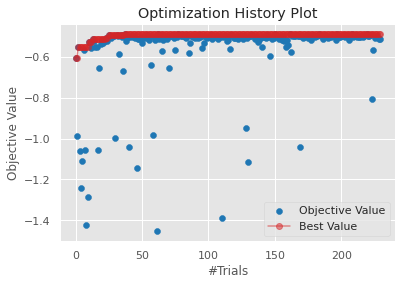

In [82]:
tuner.plot_best_scores()

### train the model with the best params

In [73]:
%%time

model = lgb.LGBMRegressor(**tuner.best_params)

model.fit(x_train, y_train, categorical_feature=cat_columns_idxs)

CPU times: user 8.42 s, sys: 34.5 ms, total: 8.46 s
Wall time: 2.13 s


LGBMRegressor(learning_rate=0.0073250798169353214, max_depth=9,
              n_estimators=2000)

### Prediction and submission to Kaggle

In [74]:
test_orig = pd.read_csv(FILE_TEST)

In [75]:
# add engineered features
# feature engineering

test_orig = add_features(test_orig)

# coding
test_orig = apply_encoders(test_orig, le_list)

# data on which do scoring
x_test = test_orig[features]

Coding: season 
Coding: weather 
Coding: year 


In [76]:
# scoring

score_test = model.predict(x_test)

### prepare submission

In [77]:
df_sub = pd.read_csv("sampleSubmission.csv")

In [78]:
# remove decimals
df_sub["count"] = np.round(score_test, 0)

# remove eventual negative
condition = df_sub["count"] < 0

df_sub.loc[condition, "count"] = 0

In [79]:
FILE_SUB_PREFIX = "sub-demo-001"
FILE_SUB = FILE_SUB_PREFIX + ".csv"

df_sub.to_csv(FILE_SUB, index=False)

### Submission

In [80]:
!kaggle competitions submit -c "bike-sharing-demand" -f $FILE_SUB -m "sub demo 001, adstuner"

100%|████████████████████████████████████████| 162k/162k [00:03<00:00, 46.9kB/s]
Successfully submitted to Bike Sharing Demand

In [83]:
print(lgb.__version__)

3.3.2
